# Modeling Extremes - Numpyro Pt 1

In [1]:
import pandas as pd
from scipy.stats import genextreme
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_url = "https://raw.githubusercontent.com/georgebv/pyextremes-notebooks/master/data/battery_wl.csv"

data = pd.read_csv(data_url, index_col=0, parse_dates=True).squeeze()
data.describe()

count    809903.000000
mean         -0.119026
std           0.533992
min          -2.122000
25%          -0.558000
50%          -0.111000
75%           0.316000
max           3.417000
Name: Water Elevation [m NAVD88], dtype: float64

## Clean Data

In [3]:
# sort ascending
data = data.sort_index(ascending=True)
# change type
data = data.astype(float)
# drop all nana
data = data.dropna()
# select start time - 1925
data = data.loc[pd.to_datetime("1925"):]
# rescale time
data = data  - (data.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3

data.describe()

count    796751.000000
mean         -0.063809
std           0.526933
min          -2.081901
25%          -0.498731
50%          -0.058581
75%           0.373429
max           3.357218
Name: Water Elevation [m NAVD88], dtype: float64

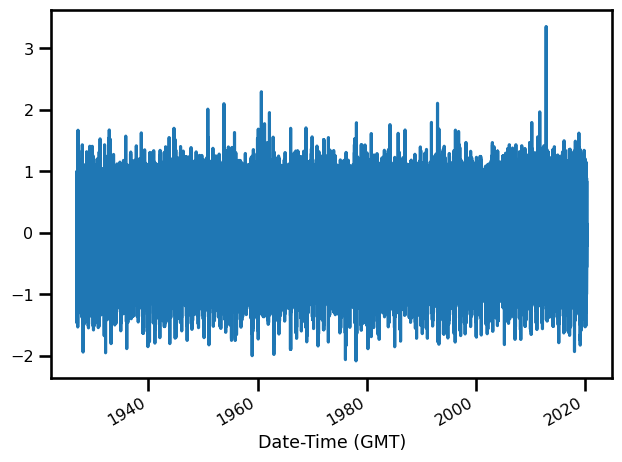

In [4]:
fig, ax = plt.subplots()

data.plot(ax=ax)

plt.tight_layout()
plt.show()

## Extremes

In [5]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

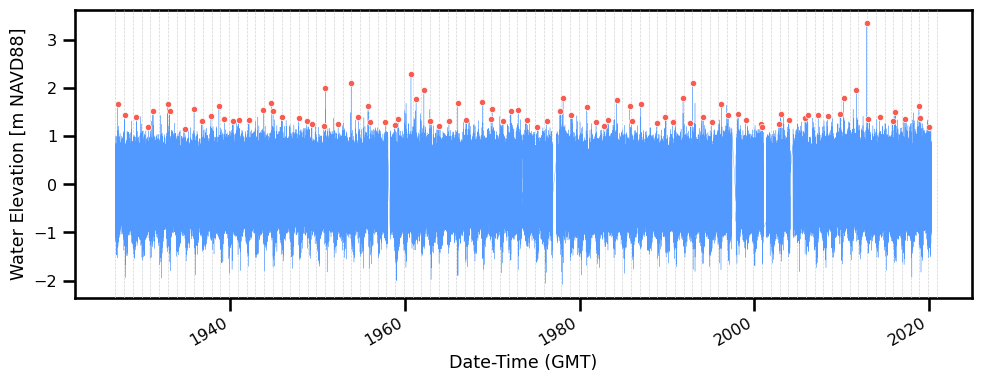

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [18]:
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd

def model(y: Float[Array, "N"]=None):
    # prior parameters
    loc = numpyro.param("loc", init_value=0.0)
    scale = numpyro.param("scale", init_value=1.0)
    concentration = numpyro.param("concentration", init_value=1.0)
    # likelihood
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

In [19]:
rng_key = jrandom.PRNGKey(123)

### Variational Distribution

In [40]:
def mle_guide(y):
    pass


### Inference

$$
\boldsymbol{\theta}^* = 
\underset{\boldsymbol{\theta}}{\text{argmin}}
\hspace{2mm}
\log \frac{1}{N}\sum_{n=1}^Np(y_n|\boldsymbol{\theta})
$$

In [24]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.05)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


In [25]:
num_steps = 100
y = extremes.values
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, y=y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 442.62it/s, init loss: 208.4142, avg. loss [96-100]: -18.0039]


### Training

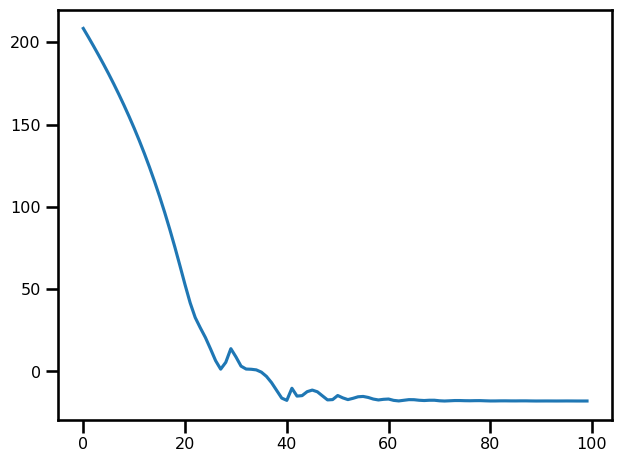

In [26]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

In [27]:
svi_result.params

{'concentration': Array(0.26941407, dtype=float32),
 'loc': Array(1.3516779, dtype=float32),
 'scale': Array(0.14713149, dtype=float32)}

### Params

In [28]:
c = svi_result.params["concentration"]
loc = svi_result.params["loc"]
scale = svi_result.params["scale"]

In [29]:
print("Parameters (MLE):")
print(f"Shape - ξ: {c:.4f}")
print(f"Loc   - μ: {loc:.4f}")
print(f"Scale - σ: {scale:.4f}")

Parameters (MLE):
Shape - ξ: 0.2694
Loc   - μ: 1.3517
Scale - σ: 0.1471


## Return Period

In [38]:
import numpy as np
from scipy.stats import genextreme

return_periods = np.logspace(-1, 3,50)

model = tfd.GeneralizedExtremeValue(loc=loc, scale=scale, concentration=c)
return_levels = model.quantile(1-1/return_periods)

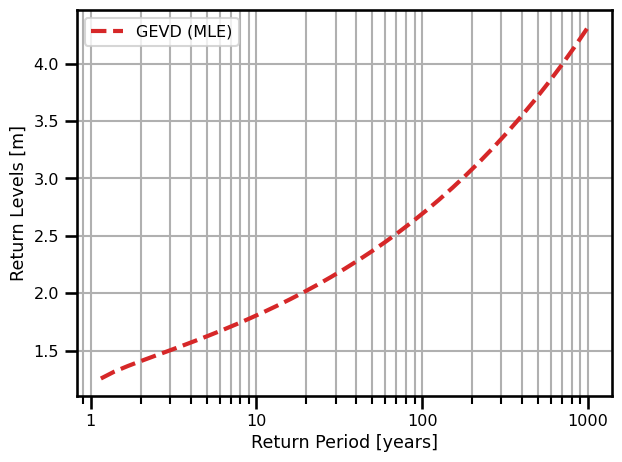

In [39]:
fig, ax = plt.subplots()

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GEVD (MLE)",
)

ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels [m]",
    xscale="log",
)
# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()